# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [1]:
X = np.array([10,3,7])
I = np.array([1,1,2,2])
print(X[I])
X = np.array([[1,2],[3,4]])
I = np.array([0,0,1])
J = np.array([1,0,1])
print(X[I,J])

NameError: name 'np' is not defined

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

Operation of transferring probability from one bucket to another doesn't change mean ($V = 1/n$).

In each step we take one untouched bucket: $B_1$ with volume < V then there's another bucket $B_2$ with volume > V (otherwise mean would be smaller than V - cannot be true). We take from another bucket desired volume to fill to V and we put away bucket $B_1$ (we will never touch it again) marking that it had some volume donated from $B_2$.

If we can't take any bucket that has volume < V it means that all of the buckets have volume >= V. It's not possible for any bucket to have volume > V since then mean > V - cannot be true - then all of buckets have volume of V.

In the end bucket will containt pieces of two $p_i$'s at max - original and donor unless it started with volume equal V or was big enough to fill other buckets still maintaining volume V.

In [1]:
import numpy as np

p = np.linspace(0, 1, num=5)

def squaring_histogram(p):
    B = np.array(p, dtype='f') # Bucket
    N = B.size

    mean = np.mean(B)
    
    Donor = np.arange(N)
    Probs = np.empty(N)
    Probs.fill(mean)
    
    while np.count_nonzero(B < mean):

        i = np.where(B < mean)[0][0]
        j = np.where(B > mean)[0][0]

        Donor[i] = j
        Probs[i] = B[i]
        
        B[j] = B[j] - (mean - B[i])
        B[i] = mean
        
    return Donor, Probs

In [2]:
import pandas as pd

data = pd.read_csv('us_births_69_88.csv')
births = np.array(data['births'])

%timeit squaring_histogram(births)

100 loops, best of 3: 5.29 ms per loop


In [ ]:
# Note - I was experimenting which function would work faster
indexes = np.arange(n)
def find_repetition_using_vec(a): # 42 sec on csv data- slower (time complexity)
    _, uniq_ind = np.unique(a, return_index=True)
#     mask = np.ones_like(indexes, dtype=bool)
    mask[uniq_ind] = False
    return(indexes[mask][0])

def find_repetition_using_set(a): # 21 sec on csv data - faster
    s = set()
    n = 0
    for v in a:
        n += 1
        
        if v in s:
            return n
        else:
            s |= {v} 
    return n

In [34]:
n = births.size
mean = np.mean(births)
K = 60

sample_days = np.random.randint(0, n-1, K)
sample_births = np.random.random_sample(K) * mean

Donor, Probs = squaring_histogram(births)

# Brutal for explained
days = []
for i in range(K):
    day = sample_days[i]
    day_prob = sample_births[i]
    
    if day_prob < Probs[day]:
        # We are below separator, we are using original value
        days.append(day)
    else:
        # We are above separator, we need to use donor's value
        days.append(Donor[day])

# Vectorizing to get the same result as in for above
use_original_value = sample_births < Probs[sample_days]
use_donor_value = ~use_original_value
sample_days[use_donor_value] = Donor[sample_days[use_donor_value]]

# Trying to figure out where repetition took place
find_repetition_using_set(sample_days)

22

# Version 1
We have all necessary pieces to create simulation

#Samples = 1000000 - runtime: 38.8825190067s


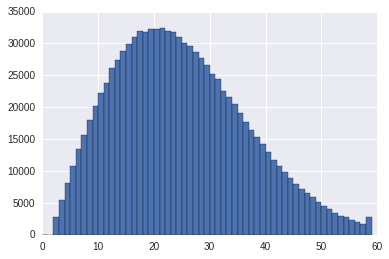

In [35]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import time
%matplotlib inline

# Times of repetition
samples = 10**6
K = 60
# Square histogram, get donors and separating probabilities
Donor, Probs = squaring_histogram(births)

start = time.time()
results = []
for i in xrange(samples):
    # Generate sample vectors
    sample_days = np.random.randint(0, n-1, K)
    sample_births = np.random.random_sample(K) * mean
    
    # Generating real values of days using squared histogram
    use_original_value = sample_births < Probs[sample_days]
    use_donor_value = ~use_original_value
    sample_days[use_donor_value] = Donor[sample_days[use_donor_value]]
    
    # Finding repetition
    results.append(find_repetition_using_set(sample_days))

end = time.time()

plt.hist(results, np.arange(K))

print("#Samples = {} - runtime: {}s".format(samples, end-start))


# Final version
now that I understand everything I will try to do **full vectorization!**

#Samples = 1000000 - runtime: 21.8179290295s


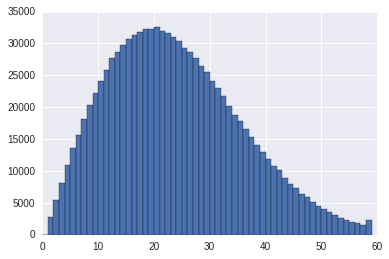

In [33]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import time
%matplotlib inline

# Times of repetition
samples = 10**6
K = 60 # K >= 80 - getting out of memory error

Donor, Probs = squaring_histogram(births)

start = time.time()
sample_days = np.random.randint(0, n-1, (samples, K))
sample_births = np.random.random_sample((samples,K)) * mean
use_original_value = sample_births < Probs[sample_days]
use_donor_value = ~use_original_value
sample_days[use_donor_value] = Donor[sample_days[use_donor_value]]

# here i can't think of anything good other than apply_along_axis
result = np.apply_along_axis(find_repetition_using_set, 1, sample_days)
end = time.time()

plt.hist(results, np.arange(K))

print("#Samples = {} - runtime: {}s".format(samples, end-start))


**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.